### STACKED PAIR MAP

In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

Stacking galaxies:   0%|          | 0/13098 [00:00<?, ?it/s]

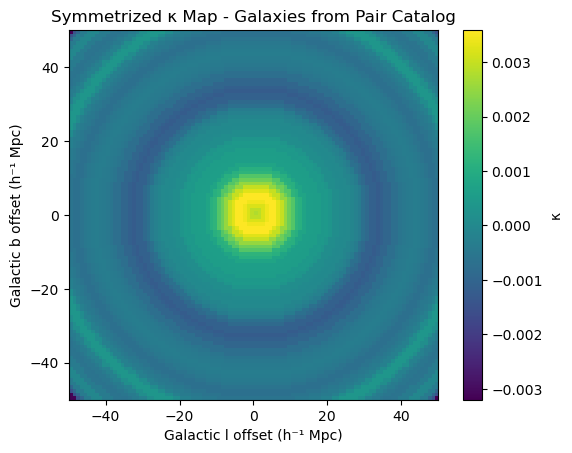

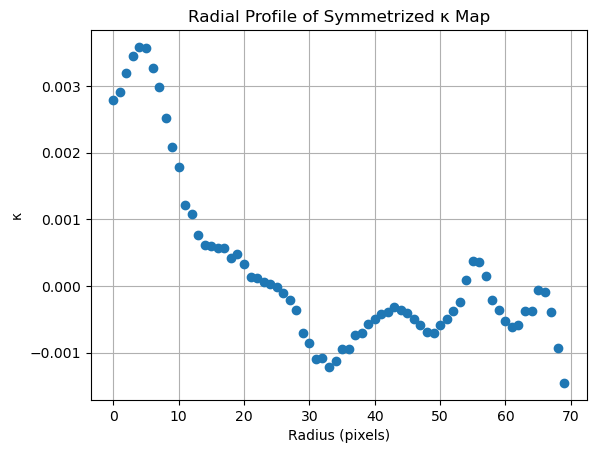

array([ 2.78890599e-03,  2.91688597e-03,  3.19667117e-03,  3.45102182e-03,
        3.58640885e-03,  3.56645956e-03,  3.26868682e-03,  2.98894068e-03,
        2.51500319e-03,  2.08006826e-03,  1.77873557e-03,  1.20924032e-03,
        1.07874851e-03,  7.64371507e-04,  6.11011391e-04,  5.92269742e-04,
        5.73572164e-04,  5.74165245e-04,  4.21898012e-04,  4.83524740e-04,
        3.34760734e-04,  1.37854523e-04,  1.21644564e-04,  5.24078445e-05,
        2.52592757e-05, -1.38151888e-05, -1.07390267e-04, -2.17751063e-04,
       -3.61705406e-04, -7.02791539e-04, -8.55334264e-04, -1.09469894e-03,
       -1.07939998e-03, -1.21272569e-03, -1.12457827e-03, -9.48991210e-04,
       -9.52367371e-04, -7.31926520e-04, -7.11877001e-04, -5.65940827e-04,
       -4.94966850e-04, -4.22636882e-04, -3.89227105e-04, -3.18693142e-04,
       -3.56323921e-04, -4.05808344e-04, -4.94962647e-04, -5.91172638e-04,
       -6.84382908e-04, -7.04242639e-04, -5.81837182e-04, -4.94054112e-04,
       -3.79885991e-04, -

In [4]:
# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/galaxy_pairs_catalog.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.concatenate([pairs['l1'], pairs['l2']]) # degrees
b_all = np.concatenate([pairs['b1'], pairs['b2']]) # degrees
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

weights = np.ones(len(l_all))  # equal weights

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map")


Stacking galaxies:   0%|          | 0/100000 [00:00<?, ?it/s]

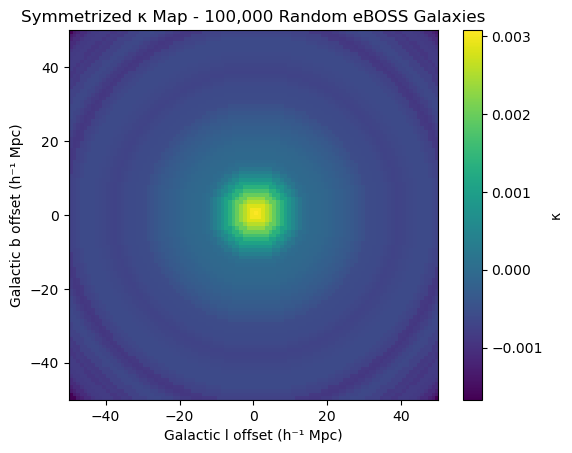

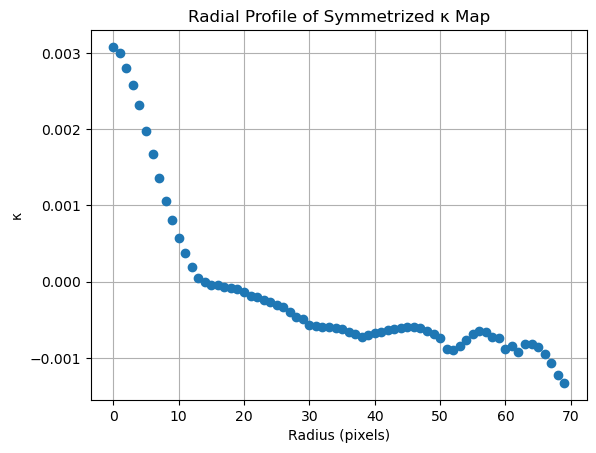

array([ 3.08003112e-03,  3.00147984e-03,  2.80730386e-03,  2.57429169e-03,
        2.31851040e-03,  1.97498459e-03,  1.67440827e-03,  1.36350850e-03,
        1.06423878e-03,  8.06282604e-04,  5.68266480e-04,  3.78596618e-04,
        1.97474212e-04,  5.18786176e-05, -7.08486366e-06, -4.47456199e-05,
       -4.24177770e-05, -7.02564479e-05, -8.51847171e-05, -9.81068220e-05,
       -1.40279217e-04, -1.85200555e-04, -2.06394965e-04, -2.34900626e-04,
       -2.63765840e-04, -3.07800193e-04, -3.37313573e-04, -3.95826128e-04,
       -4.57549825e-04, -4.96095137e-04, -5.62833022e-04, -5.81008330e-04,
       -5.92626160e-04, -5.97800880e-04, -6.02406653e-04, -6.17084755e-04,
       -6.66362763e-04, -6.81068551e-04, -7.23655379e-04, -7.02898377e-04,
       -6.79724470e-04, -6.54814696e-04, -6.39203856e-04, -6.24139224e-04,
       -6.12753503e-04, -5.98738950e-04, -5.99218573e-04, -6.09552336e-04,
       -6.52574771e-04, -6.90560445e-04, -7.39812314e-04, -8.89333980e-04,
       -8.93349780e-04, -

In [3]:
# import numpy as np
# import healpy as hp
# import matplotlib.pyplot as plt
# from astropy.cosmology import Planck18 as cosmo
# from astropy.io import fits
# from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

from helper import fast_icrs_to_galactic

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

# --- Select 100,000 random galaxies ---
num_random = 100000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 100,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map")